In [1]:
# Copyright 2025 Luke Moffett
# Licensed under the Apache License, Version 2.0

import arxiv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import tqdm
import torch

from datetime import datetime
from pathlib import Path
from IPython.display import display
from clz_or_cls import abstracts, perturbation

tqdm.tqdm.pandas()

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

plt.rcParams['figure.dpi'] = 100
%matplotlib inline

In [ ]:
# Define the search parameters
start_date = datetime(year=2023, month=10, day=1)
end_date = datetime(year=2023, month=10, day=31)
date_query = f'submittedDate:[{start_date.strftime("%Y%m%d")} TO {end_date.strftime("%Y%m%d")}]'

# Fetch papers from arXiv
search = arxiv.Search(
    query=date_query,
    max_results=5000,
)

papers = []
for i, paper_meta in tqdm.tqdm(enumerate(search.results(), start=1)):
    
    papers.append(paper_meta)
papers

In [ ]:
paper_rows = []
for paper in papers:
    paper_rows.append({
        'title': paper.title,
        'abstract': paper.summary,
        'arxiv_id': paper.entry_id,
        'publish_date': paper.published,
    })

arxiv_df = pd.DataFrame(paper_rows)
arxiv_df

In [ ]:
arxiv_df.to_csv(Path(os.environ['CORC_DATASETS_ABSTRACT_DIR']) /'abstracts.csv', index=False)

In [ ]:
from dateutil import parser
arxiv_df = pd.read_csv(Path(os.environ['CORC_DATASETS_ABSTRACT_DIR']) /'abstracts.csv')
arxiv_df['publish_datetime'] = arxiv_df['publish_date'].apply(parser.parse)
arxiv_df

In [4]:
arxiv_df['publish_datetime'].min(), arxiv_df['publish_datetime'].max()

(Timestamp('2023-10-01 00:04:29+0000', tz='tzutc()'),
 Timestamp('2023-10-09 11:47:50+0000', tz='tzutc()'))

In [5]:
abstract_df = arxiv_df
abstract_df['text'] = abstract_df['abstract'].apply(lambda x: x[:2000])

<AxesSubplot: >

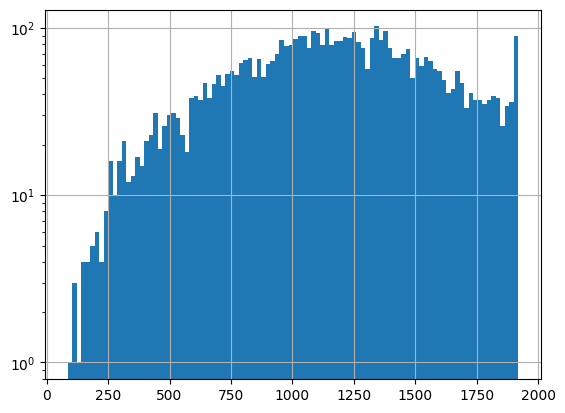

In [6]:
abstract_df['text'].str.len().hist(bins=100, log=True)

In [7]:
failures = []
for i in range(len(abstract_df)):
    try:
        abstracts.extract_replacible_tokens(abstract_df.iloc[i]['text'])
    except Exception as e:
        failures.append((i, abstract_df.iloc[i]['text']))

assert len(failures) == 0, len(failures)

In [8]:
abstract_marked_df = abstracts.abstracts_marked(as_df=True)
abstract_marked_df.columns

Index(['title', 'abstract', 'arxiv_id', 'publish_date', 'text', 'tokens',
       'replacement_candidates', 'tokenized_sentence', 'tokens_len',
       'num_replacement_candidates', 'candidate_ratio'],
      dtype='object')

<AxesSubplot: >

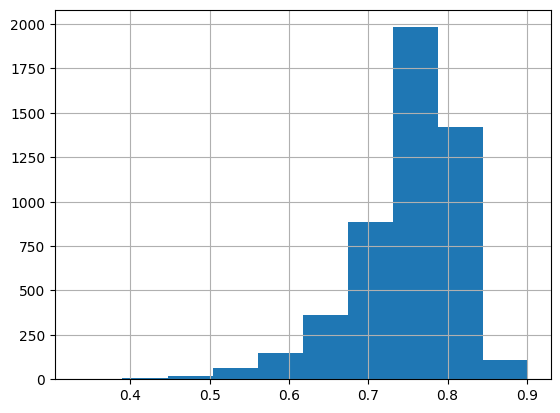

In [9]:
abstract_marked_df['candidate_ratio'].hist(bins=10)

<AxesSubplot: >

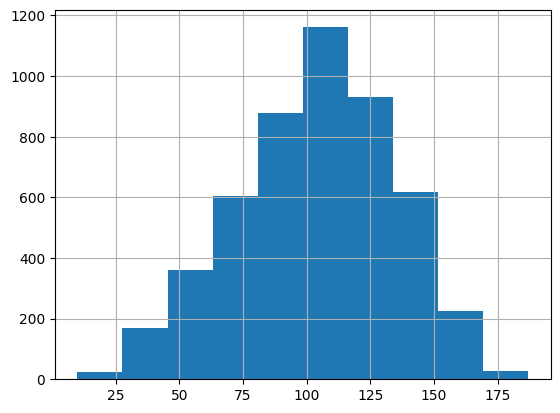

In [10]:
abstract_marked_df['tokens_len'].hist(bins=10)

# Label the Replacement Candidates

In [ ]:
abstract_marked_df['tokenized_sentence']

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/users/lam135/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     /home/users/lam135/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
100%|██████████| 5000/5000 [00:05<00:00, 890.42it/s] 


<AxesSubplot: >

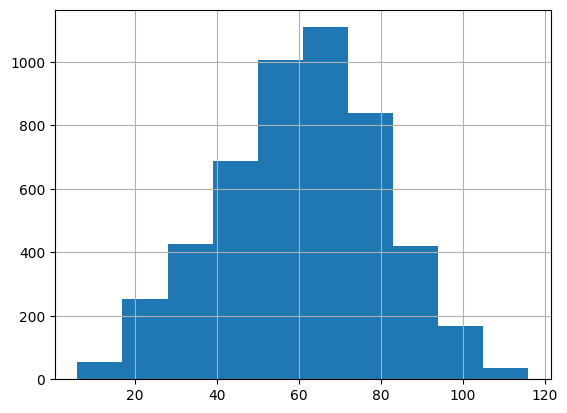

In [13]:
import nltk
from nltk.stem import PorterStemmer
# Import the stopwords from nltk.corpus
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

# Initialize the Porter Stemmer
porter = PorterStemmer()

# Get the list of English stopwords
english_stopwords = stopwords.words('english')
stopwords_set = set(english_stopwords)

def get_words_with_only_one_form(replacement_candidates):

    tokens = list(replacement_candidates)

    # Stem each word in the sentence
    stems = [porter.stem(token) for token in tokens]

    # Print the original tokens and their corresponding stems
    mapping = {}

    # Populate the mapping
    for stem, word in zip(stems, tokens):
        if stem in mapping:
            # If the key already exists, append the value to the list
            mapping[stem].add(word)
        else:
            # If the key doesn't exist, create a new entry with the value in a list
            mapping[stem] = {word}

    mapping

    unique_elements = {next(iter(words)) for stem, words in mapping.items() if len(words) == 1}
    
    return unique_elements - stopwords_set

abstract_marked_df['unique_candidates'] = abstract_marked_df['replacement_candidates'].progress_apply(get_words_with_only_one_form)
abstract_marked_df['unique_candidates_len'] = abstract_marked_df['unique_candidates'].apply(len)
abstract_marked_df['unique_candidates_len'].hist(bins=10)

In [ ]:
import random
abstract_marked_df['sorted_candidates'] = abstract_marked_df['unique_candidates'].apply(lambda x: random.sample(x, 1))
abstract_marked_df['sorted_candidates']

In [15]:
assert abstract_marked_df['sorted_candidates'].apply(len).value_counts()[1] == len(abstract_marked_df)

In [ ]:
display(abstract_marked_df.iloc[1]['text'])
display(' '.join(abstract_marked_df.iloc[1]['sorted_candidates']))

In [17]:
annotator_accs = {
    "visual": {"legit": 60.4, "dces": 83.0},
    "phonetic": {"phonee": 74.3, "zeroe_phonetic": 50.0},
    "typo": {"zeroe_noise": 68.9, "zeroe_typo": 53.3}
}

strategy_thresholds = {
    'visual': 0,
    'phonetic': 0,
    'typo': 0
}

alphas = {}

for clazz, accs in annotator_accs.items():
    (name1, acc1), (name2, acc2) = accs.items()

    alphas[clazz] = {
        'class_idx': [(0, name1), (1, name2)],
        'alpha': (65.5 - acc2) / (acc1 - acc2)
    }

alphas

{'visual': {'class_idx': [(0, 'legit'), (1, 'dces')],
  'alpha': 0.7743362831858407},
 'phonetic': {'class_idx': [(0, 'phonee'), (1, 'zeroe_phonetic')],
  'alpha': 0.6378600823045268},
 'typo': {'class_idx': [(0, 'zeroe_noise'), (1, 'zeroe_typo')],
  'alpha': 0.7820512820512818}}

In [18]:
abstract_marked_df['perturbation_buckets'] = abstract_marked_df['sorted_candidates'].apply(lambda s: np.random.rand(len(s)))
abstract_marked_df['perturbation_buckets']

0        [0.1849814650154944]
1       [0.32917200501272126]
2        [0.6575650716013947]
3        [0.8450640327814705]
4        [0.2199240711395124]
                ...          
4995    [0.21253162718409124]
4996     [0.6907117877193379]
4997     [0.9084477787054119]
4998      [0.687201298749954]
4999      [0.281975918727149]
Name: perturbation_buckets, Length: 5000, dtype: object

In [ ]:
classes = ['visual', 'phonetic', 'typo']
for clazz in classes:
    def map_rand_to_class(rand):
        alpha = alphas[clazz]['alpha']

        return (np.array(rand) >= alpha).astype(int)
    
    abstract_marked_df[f'{clazz}_buckets'] = abstract_marked_df['perturbation_buckets'].apply(map_rand_to_class)

abstract_marked_df[[f'{clazz}_buckets' for clazz in classes]]

In [20]:
abstract_marked_df.to_csv(Path(os.environ['CORC_DATASETS_ABSTRACT_DIR'])/'abstract_perturbation_metadata.csv')

# Unify Metadata

In [48]:
abstract_marked_df = pd.read_csv(Path(os.environ['CORC_DATASETS_ABSTRACT_DIR'])/'abstract_perturbation_metadata.csv')

This section is run **after** using 'abstract_perturbation_metadata.csv' to actually attack the abstracts and generate the new datasets.
See `clz_or_cls.processes.abstract_candidates.py`.

There will 6 datasets, one for each attack used.
This section unifies the attacks by class so that there is a single `visual`, `phonetic`, and `typo` file.

In [49]:
strats = {
    'visual': ('legit', 'dces'),
    'phonetic': ('phonee', 'zeroe_phonetic'),
    'typo': ('zeroe_noise', 'zeroe_typo')
}
strats

{'visual': ('legit', 'dces'),
 'phonetic': ('phonee', 'zeroe_phonetic'),
 'typo': ('zeroe_noise', 'zeroe_typo')}

In [50]:
import ast
replacements_df = None

prep_path = Path(os.environ['CORC_DATASETS_PREP_DIR']) / 'abstract'

for clazz, clazz_strats in strats.items():
    for strategy in clazz_strats:
        strat_df = pd.read_csv(prep_path/f'abstract-{strategy}.csv').set_index('Unnamed: 0')
        # strat_df.rename('index')
        strat_df[f'replacements_{strategy}'] = strat_df['sorted_candidates'].apply(ast.literal_eval)
        if replacements_df is None:
            replacements_df = strat_df[[f'replacements_{strategy}']]
        else:
            replacements_df = replacements_df.merge(strat_df[[f'replacements_{strategy}']], left_index=True, right_index=True)

replacements_df.index.rename('idx', inplace=True)
replacements_df

,replacements_legit,replacements_dces,replacements_phonee,replacements_zeroe_phonetic,replacements_zeroe_noise,replacements_zeroe_typo
idx,,,,,,
0,{'games': '↋ames'},{'games': 'ǧaᴟes'},{'games': 'getmes'},{'games': 'gaumes'},{'games': 'gaes'},{'games': 'gamas'}
1,{'embeddings': 'emḩedd⍸ngs'},{'embeddings': 'eₘbedḋingₛ'},{'embeddings': 'embeddings'},{'embeddings': 'embeddingsw'},{'embeddings': 'ebnmdidges'},{'embeddings': 'dmbeddinys'}
2,{'decreasing': 'dēcr♇asƖng'},{'decreasing': 'dĕcrèaˢĩng'},{'decreasing': 'decreasein'},{'decreasing': 'decreasing''},{'decreasing': 'drneicesag'},{'decreasing': 'decreaseng'}
3,{'dynamic': 'ῄynamic'},{'dynamic': 'dynaɰìc'},{'dynamic': 'dynamyk'},{'dynamic': 'dynimuc'},{'dynamic': 'diaynmc'},{'dynamic': 'dinamyc'}
4,{'traditional': 'tradiƫional'},{'traditional': 'traditiǒɴaƚ'},{'traditional': 'treadeitionel'},{'traditional': 'traditionalh'},{'traditional': '%tr$adit<ional'},{'traditional': 'tradicional'}
...,...,...,...,...,...,...
4995,{'original': 'o☊iginal'},{'original': 'orīginâļ'},{'original': 'oregineal'},{'original': 'originalle'},{'original': 'riginal'},{'original': 'Origional'}
4996,{'language': 'ḹӘnguƋge'},{'language': 'ļânguage'},{'language': 'linguadge'},{'language': 'langwagely'},{'language': 'lagnuage'},{'language': 'Languague'}
4997,{'diamond': 'diamОnd'},{'diamond': 'diämøɳd'},{'diamond': 'dimond'},{'diamond': 'diaumend'},{'diamond': 'dimond'},{'diamond': 'Diammond'}


In [ ]:
abstract_perturbable_with_replacements_df = abstract_marked_df.merge(replacements_df, left_index=True, right_index=True)
abstract_perturbable_with_replacements_df[['sorted_candidates', 'perturbation_buckets',
       'visual_buckets', 'phonetic_buckets', 'typo_buckets',
       'replacements_legit', 'replacements_dces', 'replacements_phonee',
       'replacements_zeroe_phonetic', 'replacements_zeroe_noise',
       'replacements_zeroe_typo']]

In [ ]:
def materialize_candidates(clazz):
    strat0, strat1 = strats[clazz]
    def materialize(row):
        
        buckets = row[f'{clazz}_buckets']
        sorted_candidates = row['sorted_candidates']
        replacements = row[f'replacements_{strat0}'], row[f'replacements_{strat1}']

        tuples = []

        for candidate, strat_idx in zip(sorted_candidates, buckets):
            tuples.append((candidate, replacements[strat_idx][candidate]))
        
        return tuples
    
    return materialize

for clazz in strats.keys():
    clazz_series = abstract_perturbable_with_replacements_df.apply(materialize_candidates(clazz), axis=1)

abstract_perturbable_with_replacements_df[[f'replacements_{clazz}' for clazz in strats.keys()]]

In [ ]:
prep_path = Path(os.environ['CORC_DATASETS_PREP_DIR'])
abstract_perturbable_with_replacements_df[[f'replacements_{clazz}' for clazz in strats.keys()]].to_csv(prep_path/'abstract'/'abstract-class-replacements.csv')

#### Sanity Check Merge

In [ ]:
prep_path = Path(os.environ['CORC_DATASETS_PREP_DIR'])
class_replacements_df = pd.read_csv(prep_path /'abstract'/'abstract-class-replacements.csv')
class_replacements_df

In [ ]:
hp_df = abstract_marked_df.merge(class_replacements_df, left_index=True, right_index=True)
hp_df

### Check that all strings can be Perturbed

In [ ]:
import ast
def perturb_for_class(clazz = 'visual'):
    def perturb_text(row):
        return perturbation.perturb_candidates(row['text'], ast.literal_eval(row[f'replacements_{clazz}']), n_candidates=1)
    return perturb_text

hp_df.progress_apply(perturb_for_class('visual'), axis=1)

In [ ]:
hp_df.progress_apply(perturb_for_class('phonetic'), axis=1)

In [ ]:
hp_df.progress_apply(perturb_for_class('typo'), axis=1)